# Konvoluční sítě pro klasifikaci

Úkolem cvičení je upravit tento notebook a dosáhnout co nejlepšího možného validačního skóre na datasetu CIFAR-10. Viz nápovědu a možné směry úprav v komentářích u jednotlivých buněk. Klasifikaci obrázků pomocí konvolučních sítí v PyTorch popisuje notebook [pytorch-convnets](lectures/pytorch-convnets.ipynb). 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models

import ans

%load_ext autoreload
%autoreload 2

## Načtení CIFAR10

In [2]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# zlepsi predzpracovani a jine augmentace skore?
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [5]:
# augmentaci lze provadet i v testovacim rezimu
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [8]:
# pomuze jina batch_size?
train_loader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=True)

## Kritérium

In [9]:
# muze zlepsit skore napr. SVM?
crit = nn.CrossEntropyLoss()
crit

CrossEntropyLoss()

## Definice konvoluční sítě

Síť definujte následující třídou `Convnet`. Architekturu síťě můžete navrhnout sami ručně, nebo lze použít jeden z existujících modelů, např. z katalogu `torchvision.models`. Není povoleno použít předtrénovaný model, tj. s vahami již natrénovanými na jiných datasetech, např. ImageNet.

In [10]:
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
stats = ans.Stats()
resnet.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Trénování a validace

In [11]:
# s novou siti musime obnovit i seznam parametru pro optimizer
# lepsich vysledku obvykle dosahuje SGD s momentum nebo napr. metoda Adam
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.1, weight_decay=0.0005)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.1
    nesterov: False
    weight_decay: 0.0005
)

In [15]:
# jaky vliv ma pocet epoch? 
# zkuste postupne menit learning rate (optimizer.param_groups[0]['lr'] = ...)
# nebo pomoci scheduleru (https://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate)
for ep in range(4):
    stats.new_epoch()
    ans.train_pytorch(resnet, crit, train_loader, optimizer, stats)
    ans.validate_pytorch(resnet, crit, test_loader, stats)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.005, momentum=0.1, weight_decay=0.0005)
for ep in range(4):
    stats.new_epoch()
    ans.train_pytorch(resnet, crit, train_loader, optimizer, stats)
    ans.validate_pytorch(resnet, crit, test_loader, stats)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.002, momentum=0.1, weight_decay=0.0005)
for ep in range(4):
    stats.new_epoch()
    ans.train_pytorch(resnet, crit, train_loader, optimizer, stats)
    ans.validate_pytorch(resnet, crit, test_loader, stats)

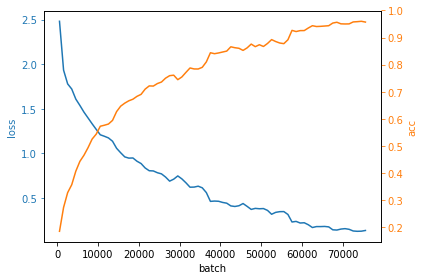

In [16]:
stats.plot_by_batch(block_len=1000)

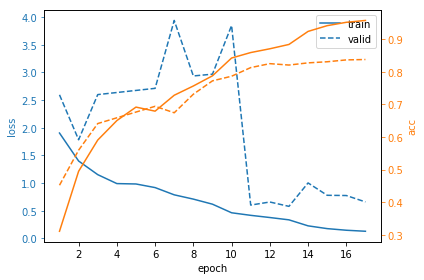

In [17]:
stats.plot_by_epoch()

In [18]:
stats.best_results()

Epoch 17,loss,acc
train,0.129810,0.95758
valid,0.660062,0.83770


## Predikce na testovacím obrázku

In [19]:
rgb_test = cv2.imread('./data/happy-green-frog.jpg')[..., ::-1]

In [20]:
ans.predict_and_show(cv2.resize(rgb_test, (32, 32)), resnet, test_transform, classes=classes)

TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>